In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline, Pipeline

# CMSE 381, Fundamental Data Science Methods
## Homework 6, Fall 2025

**Name:** Monis, Lowell

---

### Question 1: Subset selection problem

For this question, you will use the [polynomial toy data set](https://msu-cmse-courses.github.io/CMSE381-F25/_downloads/f642ded4bf0e8536ccd7675bb8d41449/polynomial-toydata.csv) from the course webpage. This is a very simple data set (check [Appendix](#appendix) for generation code), you will just predict `y` using `X`. We've learned three models in class this week.
  - Polynomial Regression 
  - Step Functions 
  - Cubic splines 

For each of these, do the following. 
  - (i) Identify the hyperparameter that is relevant to be chosen in that model (degree, number of cuts, etc.).  
  - (ii) Use k-fold CV to find the best choice of that hyperparameter. 
  - (iii) Train the model on all of the data using that chosen hyperparameter. 
  
Finally, make a plot of the data, along with all three of the learned models plotted on top. What do you notice? Is one a better (or worse choice) than the others? Which would you choose and why?

---

First, I will load the data.

In [2]:
data=pd.read_csv('../data/polynomial-toydata.csv').rename({'Unnamed: 0': ''}, axis=1).set_index('')
data.head()

,x,y
,,
0,-2.629139,-4.940311
1,2.556429,72.467439
2,0.587945,6.763137
3,-0.612074,12.080070
4,-4.595832,-92.688351


#### Polynomial regression

The polynomial regression model to predict $y$ using $x$ would be:

$$y=\sum_{p=0}^n\beta_px^p+\epsilon$$

We need to find the optimal degree of this polynomial, $n$, which will be the hyperparameter that is to be chosen.

To tune the hyperparameter, I will use $k$-fold cross-validation. I am choosing to use 10-fold cross-validation over 5-fold due to the small size of the data set, ensuring enough training data exists to make a good choice. We will do cross-validation for degrees 1 through 10. With that being said, let's tune and train this model.

4, 83.34086255120299


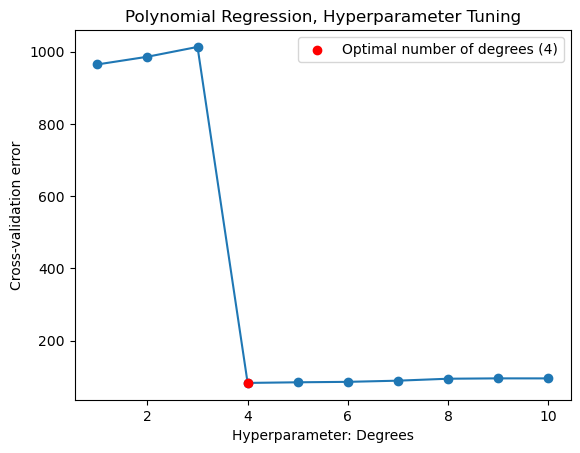

In [3]:
X = data.x.values.reshape(-1, 1)
y = data.y
degs = list(range(1,11))
kf = KFold(n_splits=10, shuffle=True, random_state=381)
mean_scores=[]
for d in degs:
    model=Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('linear', LinearRegression())
    ])
    scores=cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    mean_scores.append(-np.mean(scores))
deg_opt=np.argmin(mean_scores)+1
mse_opt=min(mean_scores)
print(deg_opt, mse_opt, sep=', ')
plt.plot(degs, mean_scores, '-o')
plt.title('Polynomial Regression, Hyperparameter Tuning')
plt.scatter(deg_opt, mse_opt, c='red', zorder=2, label=f'Optimal number of degrees ({deg_opt})')
plt.xlabel('Hyperparameter: Degrees')
plt.ylabel('Cross-validation error')
plt.legend()
plt.show()

The most optimal hyperparameter is 4 degrees, which has the lowest error at around 83.34. We can now proceed with training this model using 4 degrees on all the data together.

In [4]:
polymodel=Pipeline([
    ('poly', PolynomialFeatures(degree=deg_opt, include_bias=False)),
    ('linear', LinearRegression())
])
polymodel.fit(X,y)
print(polymodel.score(X, y))

0.9690772744894203


When trained on the entire data set with an optimal hyperparameter of 4 degrees, the model can explain 96.91% of the variance in the data. The model can be written out as follows:

In [5]:
polymodel.named_steps['linear'].coef_, polymodel.named_steps['linear'].intercept_

(array([-22.08618093,  -3.84263289,   5.75682445,   0.96852444]),
 18.535353194447353)

$$y=18.54-22.09x-3.84x^2+5.76x^3+0.97x^4+\epsilon$$

#### Step functions

The step function model to predict $y$ using $x$ using $k$ cuts and step function $C_p$ would be:

$$y=\beta_0+\sum_{p=1}^k\beta_p C_p(x)$$

We need to find the optimal number of cuts to make to the data, $k$, which will be the hyperparameter that is to be chosen.

To tune the hyperparameter, I will use $10$-fold cross-validation again. We will do cross-validation for value from 1 through 10. With that being said, let's tune and train this model. Here, I am creating a pipeline to account for data leakage during cross-validation.

15, 871.6642539510378


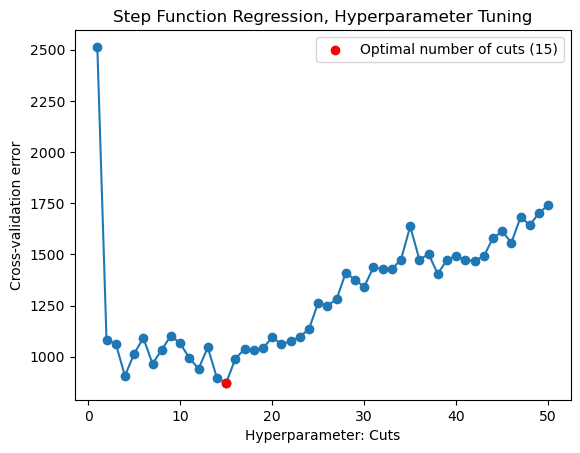

In [6]:
cuts=list(range(1,51))
kf = KFold(n_splits=10, shuffle=True, random_state=381)
mean_scores=[]
for k in cuts:
    def create_bins(X):
        df_cut = pd.cut(X, k, right=False)
        return pd.get_dummies(df_cut)
    pipeline = Pipeline([
        ('binner', FunctionTransformer(create_bins)),
        ('model', LinearRegression())
    ])
    scores = cross_val_score(pipeline, data.x, y, scoring='neg_mean_squared_error', cv=kf)
    mean_scores.append(-np.mean(scores))
cut_opt=np.argmin(mean_scores)+1
mse_opt=min(mean_scores)
print(cut_opt, mse_opt, sep=', ')
plt.plot(cuts, mean_scores, '-o')
plt.title('Step Function Regression, Hyperparameter Tuning')
plt.scatter(cut_opt, mse_opt, c='red', zorder=2, label=f'Optimal number of cuts ({cut_opt})')
plt.xlabel('Hyperparameter: Cuts')
plt.ylabel('Cross-validation error')
plt.legend()
plt.show()

#### (b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [8]:
df_steps_dummies

NameError: name 'df_steps_dummies' is not defined

I am using the mean squared error to calculate the test error for this model, which is given as follows:

In [7]:
mean_squared_error(y_test, model.predict(X_test))

665249.6845421843

In [8]:
r2_score(y_test, model.predict(X_test))

0.9392250767406248

#### (c)  Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.

First, I normalize the data set.

In [9]:
transformer = StandardScaler().fit(X_train).set_output(transform = 'pandas')
X_tr_norm = transformer.transform(X_train).drop(['const'],axis=1)
X_te_norm = transformer.transform(X_test).drop(['const'],axis=1)

I will be using Leave-One-Out Cross Validation to determine the best value of $\lambda$, or in this case $\alpha$. We create a wide range of potential values and then run a cross-validation ridge regression model. We exclude 0.

In [10]:
alphas = 10**np.linspace(4,-2,100)*0.5
alphas_cv = alphas[alphas>0]
ridgecv = RidgeCV(alphas = alphas_cv, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_tr_norm, y_train)
alpha = ridgecv.alpha_
print(alpha)

0.005


The optimal value for $\lambda$ is $0.005$ as determined by this cross-validation. I can now proceed with calculating the test MSE.

In [11]:
mean_squared_error(y_test, ridgecv.predict(X_te_norm))

665246.4290323145

In [12]:
r2_score(y_test, ridgecv.predict(X_te_norm))

0.9392253741528103

I will now loop through all the potential $\lambda$ values and plot the associated test error to justify my choice of $\lambda$. I plot a marker for the $\lambda$ value associated with the lowest test MSE, along with the chosen $\lambda=0.005$ via cross-validation. 

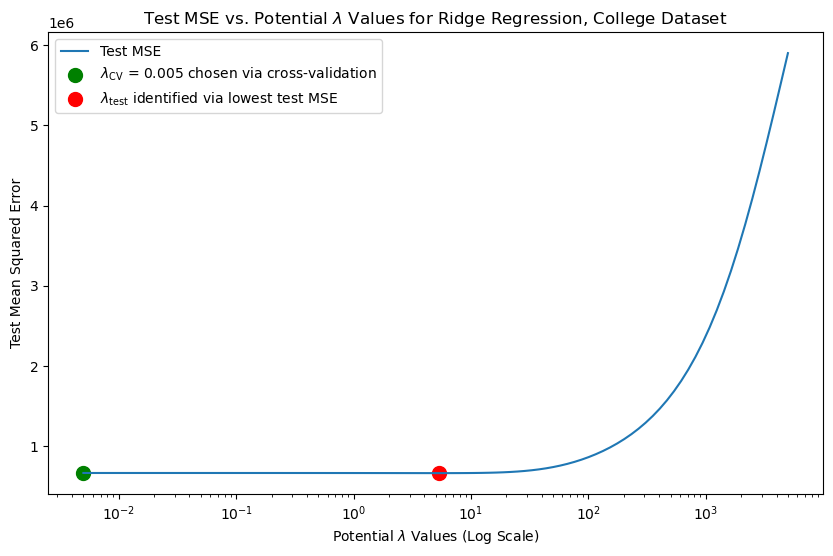

In [13]:
errors = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_tr_norm, y_train)
    test_error = mean_squared_error(y_test, ridge.predict(X_te_norm))
    errors.append(test_error)
plt.figure(figsize=(10, 6))
plt.plot(alphas, errors, label='Test MSE')
plt.scatter(alpha, mean_squared_error(y_test, ridgecv.predict(X_te_norm)),
            color='green', marker='o', s=100, label=f'$\\lambda_\\text{{CV}}$ = {alpha} chosen via cross-validation')
plt.scatter(alphas[np.argmin(errors)], errors[np.argmin(errors)],
            color='red', marker='o', s=100, label='$\\lambda_\\text{test}$ identified via lowest test MSE')
plt.title('Test MSE vs. Potential $\\lambda$ Values for Ridge Regression, College Dataset')
plt.xlabel('Potential $\\lambda$ Values (Log Scale)')
plt.ylabel('Test Mean Squared Error')
ax=plt.gca()
ax.set_xscale('log')
plt.legend()
plt.show()

Clearly,  $\lambda=0.005$ is a good value for the regularization parameter, since it is associated with very low test error. When test MSE is used as a metric, $\lambda$ values of order between 0 and 1 also provide low error, as observed on the above plot.

#### (d) Fit a lasso model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

I can reuse the normalized data from part (c). Since `LassoCV()` automatically finds good choices of the regularization parameter for you, I will not be passing a list `alphas` to the method. I will reuse that array later for justifying my choice via a plot. The `LassoCV()` method uses a 5-fold cross-validation by default.

In [14]:
lassocv = LassoCV(random_state=381).fit(X_tr_norm, y_train)
alpha = lassocv.alpha_
print(alpha)

17.598043523672352


The optimal value for $\lambda$ is $17.598$ as determined by this cross-validation. I can now proceed with calculating the test MSE.

In [15]:
mean_squared_error(y_test, lassocv.predict(X_te_norm))

643492.5095449584

In [16]:
r2_score(y_test, lassocv.predict(X_te_norm))

0.9412127374213017

I will now count the number of non-zero coefficients.

In [17]:
print(np.sum(np.abs(lassocv.coef_) > 0))

15


There are 15 non-zero coefficients.

I will now loop through all the potential $\lambda$ values and plot the associated test error to justify my choice of $\lambda$. I plot a marker for the $\lambda$ value associated with the lowest test MSE, and check if it matches $\lambda=17.598$.

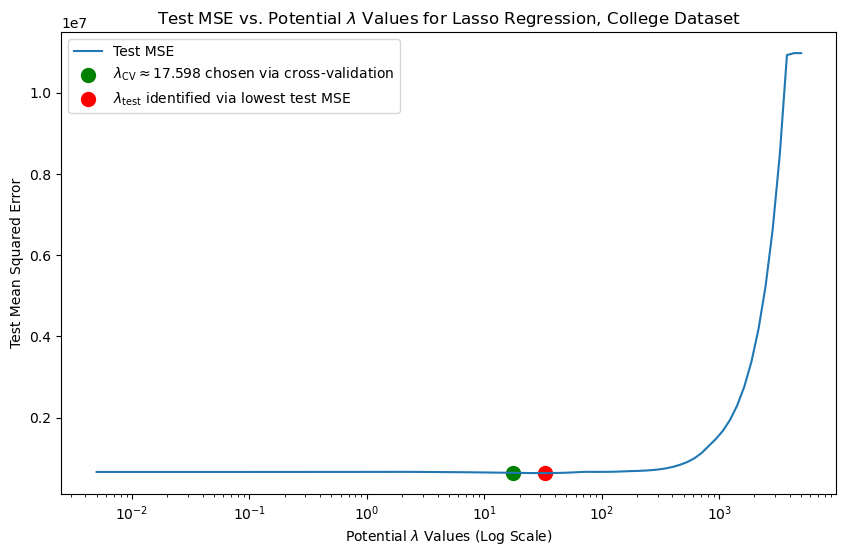

In [18]:
coefs = []
errors = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_tr_norm, y_train)
    test_error = mean_squared_error(y_test, lasso.predict(X_te_norm))
    coefs.append(lasso.coef_)
    errors.append(test_error)
plt.figure(figsize=(10, 6))
plt.plot(alphas, errors, label='Test MSE')
plt.scatter(alpha, mean_squared_error(y_test, lassocv.predict(X_te_norm)),
            color='green', marker='o', s=100, label=f'$\\lambda_\\text{{CV}} \\approx${alpha:.3f} chosen via cross-validation')
plt.scatter(alphas[np.argmin(errors)], errors[np.argmin(errors)],
            color='red', marker='o', s=100, label='$\\lambda_\\text{test}$ identified via lowest test MSE')
plt.title('Test MSE vs. Potential $\\lambda$ Values for Lasso Regression, College Dataset')
plt.xlabel('Potential $\\lambda$ Values (Log Scale)')
plt.ylabel('Test Mean Squared Error')
ax=plt.gca()
ax.set_xscale('log')
plt.legend()
plt.show()

Clearly,  $\lambda=17.598$ is a good value for the regularization parameter, since it is associated with very low test error. When test MSE is used as a metric, $\lambda$ values of order between 1 and 2 also provide low error, as observed on the above plot.

Now, I will create a plot of the number of non-zero coefficients  as a function of  the choice of $\lambda$ values

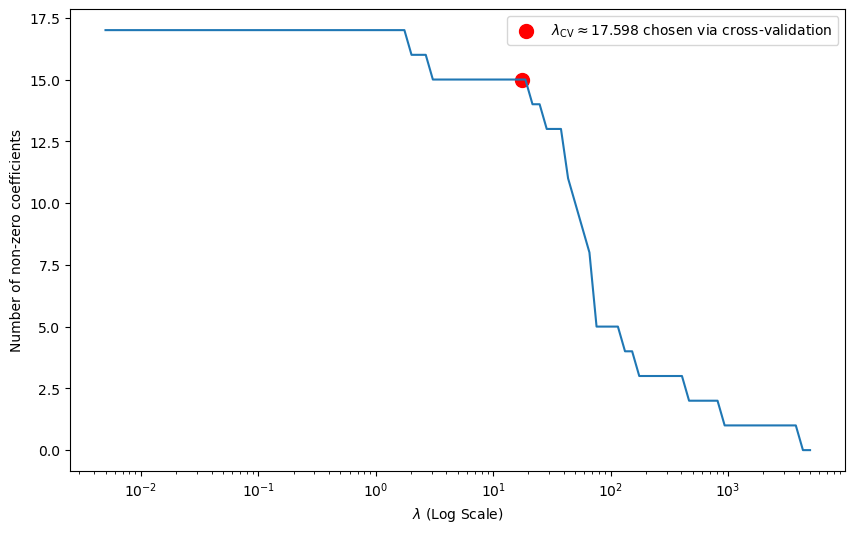

In [19]:
non_zero_counts = np.count_nonzero(coefs, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(alphas, non_zero_counts)
plt.scatter(alpha, np.sum(np.abs(lassocv.coef_) > 0),
           color='red', marker='o', s=100, label=f'$\\lambda_\\text{{CV}} \\approx${alpha:.3f} chosen via cross-validation')
plt.xscale('log')
plt.legend()
plt.xlabel('$\\lambda$ (Log Scale)')
plt.ylabel('Number of non-zero coefficients')
plt.show()

The above plot verifies the model's claim that there are 15 non-zero coefficients for the associated optimal $\lambda$ value.

#### (e) Fit a PCR model on the training set, with $M$ chosen by cross-validation. Report the test error obtained, along with the value of $M$ selected by cross-validation.

First, I will create a PCA object and fit it with scaled data. I will also create a linear regression object. After this, I will train the linear regression model for each value of $M$ and compute the 10-fold CV error, as well as the test error. Below are the optimal value of $M$, the minimal cross-validation error, and the test error obtained for the optimal value of $M$. I have also created a plot showing the cumulative explained variance ratio.

Optimal number of principal components using 10-fold CV: 17
Minimal cross-validation error associated with 17 PCs: 1624553.076487689
Test MSE for M=17: 665249.6845430702


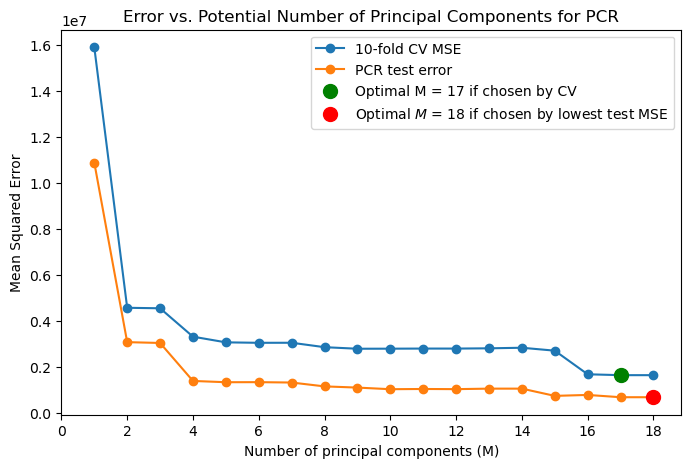

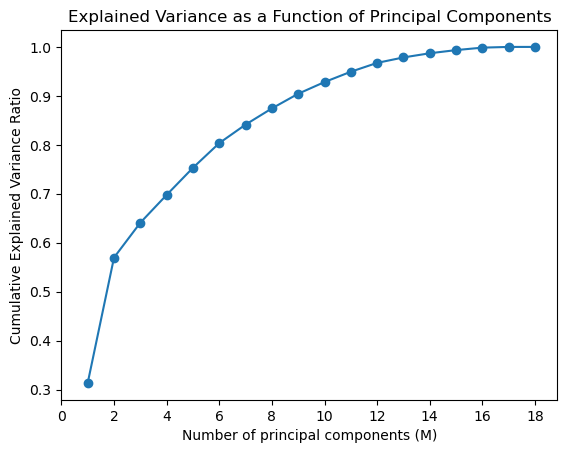

In [23]:
cv_mse = []
errors = []
for M in range(1, X_train.shape[1] + 1):
    model = make_pipeline(StandardScaler(), PCA(n_components=M), LinearRegression())
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    cv_mse.append(-scores.mean())
    model.fit(X_train, y_train)
    errors.append(mean_squared_error(y_test, model.predict(X_test)))
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
M_opt = np.argmin(cv_mse) + 1
min_cv_mse = cv_mse[M_opt - 1]
print("Optimal number of principal components using 10-fold CV:", M_opt)
print("Minimal cross-validation error associated with", M_opt, "PCs:", min_cv_mse)
print("Test MSE for M=", M_opt,": ", errors[M_opt-1], sep="")

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, X_train.shape[1] + 1), cv_mse, '-o', zorder=0, label='10-fold CV MSE')
plt.plot(np.arange(1, X_train.shape[1] + 1), errors, '-o', label='PCR test error')
plt.scatter(M_opt, min_cv_mse,
            color='green', marker='o', label=f'Optimal M = {M_opt} if chosen by CV', zorder=2, s=100)
plt.scatter(np.argmin(errors) + 1, errors[np.argmin(errors)],
            color='red', marker='o', s=100,
            label=f'Optimal $M$ = {np.argmin(errors)+1} if chosen by lowest test MSE', zorder=2)
plt.xlabel('Number of principal components (M)')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Potential Number of Principal Components for PCR')
plt.xticks(np.arange(0, X_train.shape[1] + 1,2))
plt.legend()
plt.show()
plt.plot(np.arange(1, X_train.shape[1] + 1), cumulative_variance, '-o')
plt.xlabel('Number of principal components (M)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance as a Function of Principal Components')
plt.xticks(np.arange(0, X_train.shape[1] + 1,2))
plt.show()

The reason I have added all these extra elements to the plots is to show that while the question asks for the optimal $M$ _chosen by cross-validation_, it is always better to use the $M$ value after which there is only marginal decline in error, or the $M$ value where 90% of variance is explained. The goal of PCA is dimension reduction, and the optimal value $M=17$ chosen by cross-validation does not reduce the dimensions of the data at all. So while the question is asking me to provide the optimal value by cross-validation, if I were to do my own analysis, I would probably choose a value between 4 and 8, since after 4, there is very marginal change in error (changes are smaller after 8), and 90% of variance is explained at 8 principal components.

I will now recreate the PCR model for $M=17$ and calculate the error as a sanity check.

In [21]:
pcr_model = make_pipeline(StandardScaler(), PCA(n_components=M_opt), LinearRegression())
pcr_model.fit(X_train, y_train)
mean_squared_error(y_test, pcr_model.predict(X_test))

665249.6845430702

In [22]:
r2_score(y_test, pcr_model.predict(X_test))

0.9392250767405439

#### (g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

I have created a table for the error values associated with the most optimal selections of the hyperparameter of each model.

| Model                   | Tuning parameter | Test MSE      | $R^2$  | Notes                                            |
| ----------------------- | ---------------- | ------------- | ------ | ------------------------------------------------ |
| OLS                     | –                | 665249.68     | 0.9392 | Baseline model with 18 predictors                |
| Ridge Regression        | $\lambda=0.005$  | 665246.43     | 0.9392 | Nearly identical to OLS due to less shrinkage    |
| Lasso Regression        | $\lambda=17.598$ | **643492.51** | 0.9412 | 3 predictors removed, 15 non-zero coefficients   |
| PCR                     | $M=17$           | 665249.68     | 0.9392 | Same as OLS (no effective dimension reduction)   |

The test mean squared errors for the four models (OLS, ridge regression, lasso regression, and PCR) are all very similar, ranging from approximately 643000 to 665000. The ridge and PCR models perform almost identically to OLS, suggesting that multicollinearity and overfitting are not major concerns while the model generalizes. The lasso model achieves a slightly lower test error, implying that excluding some predictors may marginally improve generalization. Overall, the differences in predictive performance among the methods are small, and all capture roughly the same underlying linear relationships in the data. All models achieve an $R^2$ around 0.94, meaning they explain roughly 94% of the variance in the number of college applications received. Linear relationships capture most of the predictive signal. The lasso provides a marginal improvement while also performing feature selection, making it arguably the most efficient model. Differences in test error are minimal, so model choice could depend more on interpretability or simplicity than predictive gains, like a choice of lower $M$ in PCR.

The models show that the number of college applications can be predicted with high accuracy, but that must be taken with a grain of salt due to the significant test MSE. Differences among OLS, Ridge, and PCR are negligible, suggesting that regularization and dimension reduction offer little improvement for this dataset. The lasso model achieves the best performance with fewer predictors, indicating some redundancy among variables. Overall, the models generalize well and capture most of the variance in the response variable.

### Appendix

The following code was used to generate the polynomial toy data. Attribution is being provided to the Department of Computational Mathematics, Science, and Engineering, and Dr. Elizabeth Munch.

Text(0.5, 1.0, 'Toy data: Basis functions')

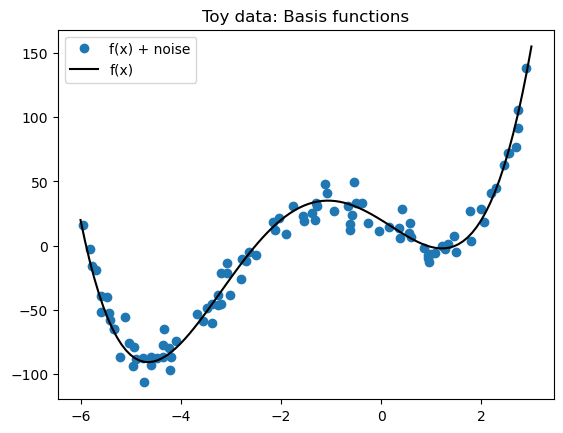

In [3]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the polynomial
f = lambda x: (x+2)*(x-2)*(x+6)*x+20

# Generate data 
x_data = np.random.uniform(-6, 3, 100)
y_data = f(x_data) + np.random.normal(0, 10, size=x_data.shape)

# Generate data for plotting 
x_plot = np.linspace(-6, 3, 100)
y_plot = f(x_plot)

# Create a DataFrame to store the data
toy_data = pd.DataFrame({'x': x_data, 'y': y_data})

plt.plot(x_data,y_data, 'o', label = 'f(x) + noise')
plt.plot(x_plot, y_plot, 'k', label = 'f(x)')
plt.legend()
plt.title('Toy data: Basis functions')